In [1]:
using LinearAlgebra
using Flux
using Plots
using Random

In [2]:

function set_LSTM_Prob(in::Int, hid::Int, op::String)
    input_num = in
    hidden_num = hid
    #middle_num = mid
    if(op=="clip1")
        opt = Flux.Optimise.Optimiser(ClipValue(1e-1),Adam(1e-1))
    elseif(op=="clip2")
        opt = Flux.Optimise.Optimiser(ClipValue(1e-2),Adam(1e-2))
    elseif(op=="clip3")
        opt = Flux.Optimise.Optimiser(ClipValue(1e-3),Adam(1e-3))
    elseif(op=="rms")
        opt = RMSProp()
    elseif(op=="gd")
        opt = Descent()
    elseif(op=="adab")
        opt = AdaBelief()
    else
        opt = ADAM()
    end
    model = Chain(LSTM(in => hid),Dense(hid => 1))
    
    return input_num, hidden_num, opt, model
end 

set_LSTM_Prob (generic function with 1 method)

In [3]:

function gene_rand2(N_site::Int)
    sig = zeros(Float32, 2)
    sig = Float32(2pi) *rand(Float32, 2, N_site) .- Float32(pi)
    return sig
end

function ThetaToSigma(theta::Vector{Float32})
    sigma = [cos(theta[1]), sin(theta[1])*exp(1.0im*theta[2])]
    return sigma
end


ThetaToSigma (generic function with 1 method)

In [7]:
a_test = ThetaToSigma(gene_rand2(10)[:,1])

2-element Vector{ComplexF64}:
 0.021167680621147156 + 0.0im
   0.8156004230488697 + 0.5782282355637914im

In [4]:
s_vec = [[1.0 0.0; 0.0 1.0], [0.0 1.0; 1.0 0.0], [0.0 -1.0im; 1.0im 0.0], [1.0 0.0; 0.0 -1.0]]

4-element Vector{Matrix{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im]
 [0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im -0.0 - 1.0im; 0.0 + 1.0im 0.0 + 0.0im]
 [1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im]

In [5]:
struct Ham
    N_site::Int
    J::Vector{Float64}
    h::Vector{Float64}
    onsite::Matrix{ComplexF64}
    NN_int::Array{ComplexF64, 4}
end

In [6]:
function set_Ham(Ns::Int, Jv::Vector{Float64}, hv::Vector{Float64})
    N_site = Ns
    J = Jv
    h= hv
    onsite = h' * s_vec
    NN_int = zeros(ComplexF64, 4, 2, 2, 2)
    for i in 1:4
        NN_int[i,1,:,:] = J[i] * s_vec[i]
        NN_int[i,2,:,:] = s_vec[i]
    end

    return N_site, J, h, onsite, NN_int 
end

set_Ham (generic function with 1 method)

In [19]:
th_test = rand(Float32, 2)
XX = 0.0
XX = f(sum(model(th_test)))
XX

0.47852749257218063

In [31]:
function loss(model, H::Ham, Ns::Int)
    E = 0.0
    for sample in 1:Ns
        Flux.reset!(model)
        θ = rand(Float32, 2, H.N_site)
        weight = 1.0
        ee = 0.0
        for i in 1:H.N_site
            st_i = ThetaToSigma(θ[:,i])
            #p = model(θ[:,i])
            #weight *= f(p'*p)
            weight *= f(sum(model(θ[:,i])))
            E += real(tr(st_i' * H.onsite * st_i))
            
            if(i > 1) 
                st_im = ThetaToSigma(θ[:,i-1])
                for x in 1:size(H.NN_int)[1]
                    ee += real((st_im' * H.NN_int[x,1,:,:] * st_im)*(st_i' * H.NN_int[x,2,:,:] * st_i))
                end
            end
        end
        E += weight * ee
    end
    return E
end

loss (generic function with 2 methods)

In [30]:
f(x) = 1.0/(1.0+exp(0.01*x))

f (generic function with 1 method)

In [24]:
N_sample = 10000
input_num, hidden_num, opt, model = set_LSTM_Prob(2, 50 , "ADAM")

(2, 50, Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), Chain(Recur(LSTMCell(2 => 50)), Dense(50 => 1)))

In [23]:
H_test = Ham(set_Ham(10, [0.0, 0.0, 0.0, 1.0], [0.0, 0.5, 0.0, 0.0])...)

Ham(10, [0.0, 0.0, 0.0, 1.0], [0.0, 0.5, 0.0, 0.0], ComplexF64[0.0 + 0.0im 0.5 + 0.0im; 0.5 + 0.0im 0.0 + 0.0im], [0.0 + 0.0im 1.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; 1.0 + 0.0im 1.0 + 0.0im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im; 0.0 + 0.0im 0.0 + 1.0im; 0.0 + 0.0im 0.0 + 0.0im;;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im; -0.0 - 0.0im -0.0 - 1.0im; 0.0 + 0.0im 0.0 + 0.0im;;; 0.0 + 0.0im 1.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im; -1.0 + 0.0im -1.0 + 0.0im])

In [28]:
l_it = zeros(Float64, N_sample)
for i in 1:N_sample
    l = 0.0
    grads = Flux.gradient(Flux.params(model)) do
        #l_it[i] = 
        l = loss(model, H_test)
    end
    Flux.Optimise.update!(opt, Flux.params(model), grads)
    l_it[i]= l
end

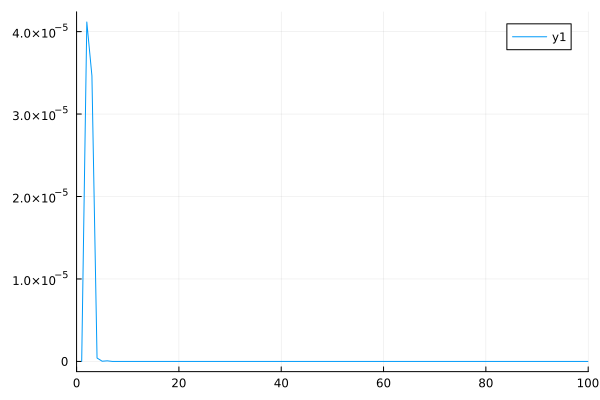

In [29]:
plot(l_it, xrange=(0,100))